In [32]:
%matplotlib inline
from utils import utils
import canny_edge_detector as ced
import matplotlib.pyplot as plt
import cv2

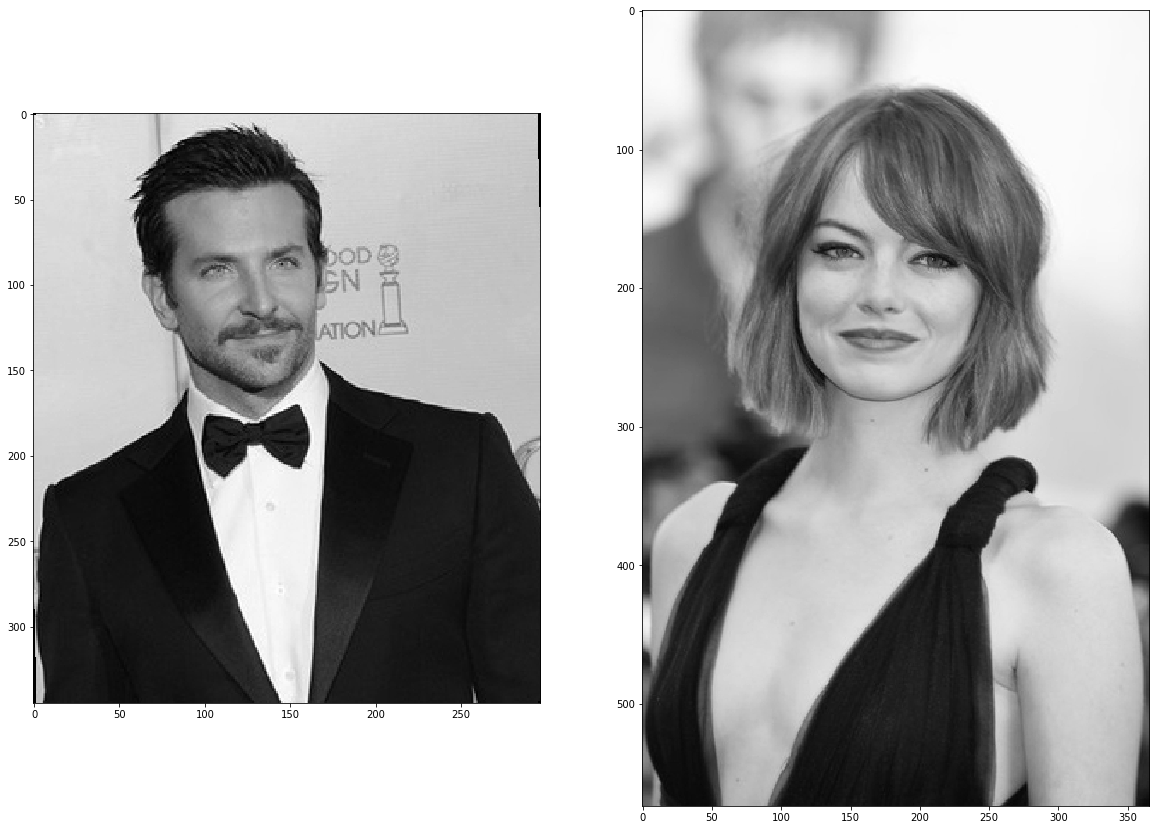

In [33]:
imgs = utils.load_data()
utils.visualize(imgs, 'gray')

In [61]:
print('lad', imgs[0].shape)
print('lass', imgs[1].shape)
#detector = ced.cannyEdgeDetector(imgs, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)

lad (345, 297)
lass (574, 366)


2

[[0.0121 0.0261 0.0337 0.0261 0.0121]
 [0.0261 0.0561 0.0724 0.0561 0.0261]
 [0.0337 0.0724 0.0935 0.0724 0.0337]
 [0.0261 0.0561 0.0724 0.0561 0.0261]
 [0.0121 0.0261 0.0337 0.0261 0.0121]]


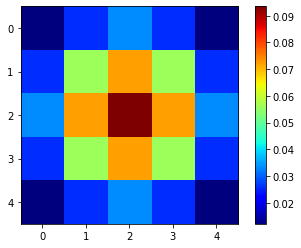

In [169]:
import numpy as np
def gaussian_kernel(size, sigma):
    size = int(size)
    x, y = np.mgrid[-size:size+1, -size:size+1]
    #print(x, y)
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    # technically not a true gaussian kernel, but sum(ker) == 1 is more important than closer approx. of gaus. dist. 
    g /= np.abs(g).sum() #(2*np.pi*sigma**2)
    return g 
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(2, 1.4)
print(np.round(gaussian_kernel_array, 4))
# print(np.sum(gaussian_kernel_array))
# x_ker = cv2.getGaussianKernel(5,1.4)
# y_ker = cv2.getGaussianKernel(5,1.4)
# xy = x_ker * y_ker.T
# print(np.round(xy, 4))
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()


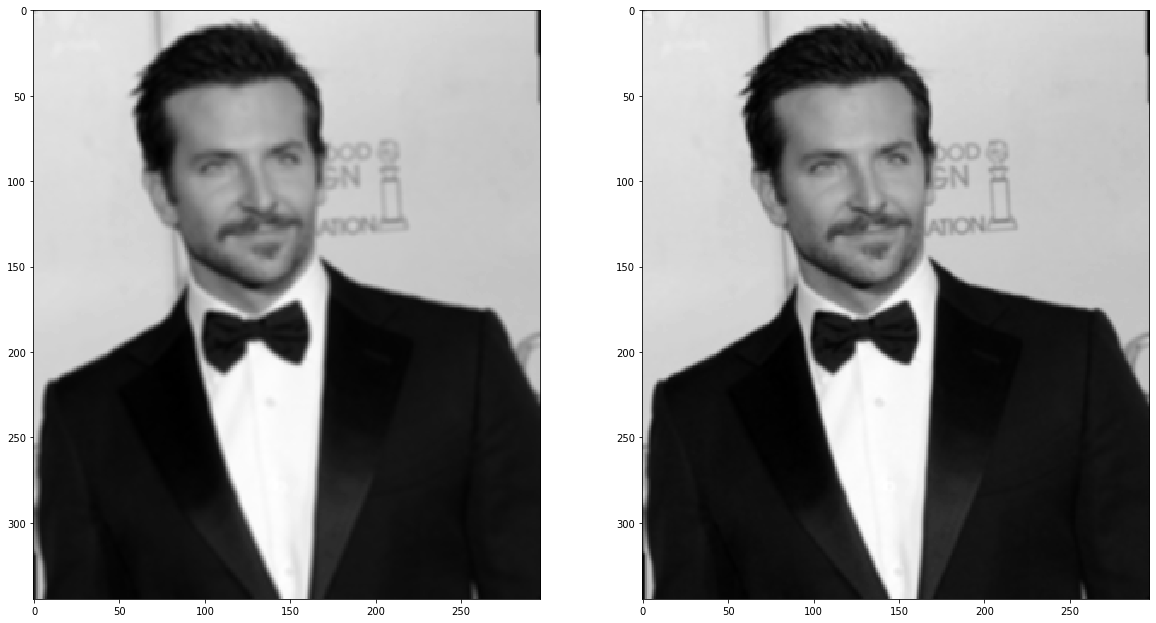

False


In [170]:
# a = [[1,2,3,4,5],
#      [1,2,3,4,5],
#      [1,2,3,4,5],
#      [1,2,3,4,5],
#      [1,2,3,4,5]]
# print(np.pad(a, 2, 'reflect'))
def gaussian_blur(img, k_size, sigma):
    assert len(imgs[0].shape) == 2 #must be greyscale img w/ dims=h*w
    ker = gaussian_kernel(k_size, sigma)
    # pad img w/ reflection 
    padded_img = np.pad(img, k_size, 'reflect')
    out_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k_i in range(1+2*k_size):
                for k_j in range(1+2*k_size):
                    out_img[i,j] += padded_img[i+k_i,j+k_j]*ker[k_i,k_j]
    return out_img

blurred_lad = gaussian_blur(imgs[0], 2, 1.4)
opencv_lad = cv2.GaussianBlur(imgs[0],(5,5), 1,4)
lads = [blurred_lad, opencv_lad]
utils.visualize(lads, 'gray')
print(np.allclose(blurred_lad, opencv_lad))
#assert (opencv_lad == blurred_lad).all()

In [162]:
def sobel_filter(img):
    #der_x = 1  der_y = 1
    k_size = 1
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    padded_img = np.pad(img, k_size, 'reflect')  
    out_img = np.zeros_like(img)
    theta = np.zeros_like(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grad_x, grad_y = 0,0
            for k_i in range(1+2*k_size):
                for k_j in range(1+2*k_size):
                    grad_x += padded_img[i+k_i,j+k_j]*sobel_x[k_i,k_j] 
                    grad_y += padded_img[i+k_i,j+k_j]*sobel_y[k_i,k_j] 
            out_img[i,j] = np.sqrt(grad_x**2 + grad_y**2)
            theta[i,j] = np.arctan2(grad_y, grad_x)
    #out_img = out_img / out_img.max() * 255
    return out_img, theta

                    

8.997227419354234 248.51679053784886
0.0 255.0
0.0 68.62724337755955


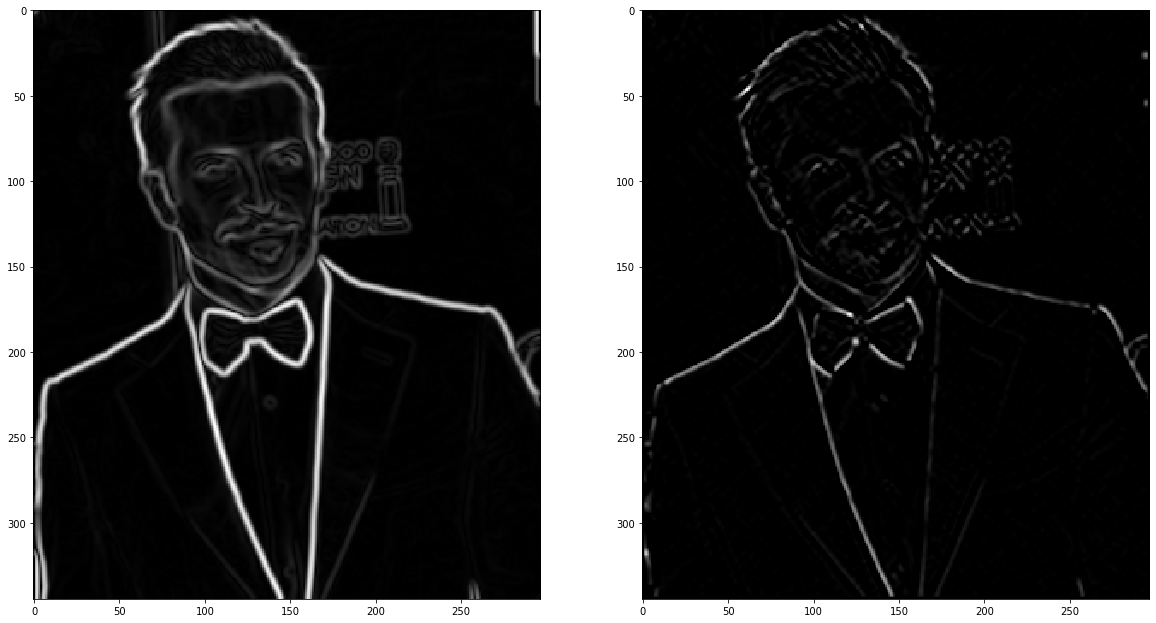

AssertionError: 

In [176]:
sobel_lad, theta = sobel_filter(lads[0])
cv2_sobel = cv2.Sobel(lads[0], cv2.CV_64F, 1, 1, ksize=3)
cv2_sobel[cv2_sobel < 0] = 0
#cv2_sobel = cv2_sobel / cv2_sobel.max() * 255
# cv2_sobelx = cv2.Sobel(lads[1], cv2.CV_64F, 1, 0)
# cv2_sobely = cv2.Sobel(lads[1], cv2.CV_64F, 0, 1)
sobel_lads = [sobel_lad, cv2_sobel]
print(np.min(lads[0]), np.max(lads[0]))
print(np.min(sobel_lads[0]), np.max(sobel_lads[0]))
print(np.min(sobel_lads[1]), np.max(sobel_lads[1]))

utils.visualize(sobel_lads, 'gray')

assert (sobel_lads[0] == sobel_lads[1]).all()
# for i in range(sobel_lads[0].shape[0]):
#     for j in range(sobel_lads[0].shape[1]):
#         print(sobel_lads[0][i,j], sobel_lads[1][i,j])
# blurred_lad = gaussian_blur(imgs[0], 2, 1.4)
# opencv_lad = cv2.GaussianBlur(imgs[0],(5,5), 1,4)
# lads = [blurred_lad, opencv_lad]
# assert opencv_lad.all() == blurred_lad.all()
# utils.visualize(lads, 'gray')

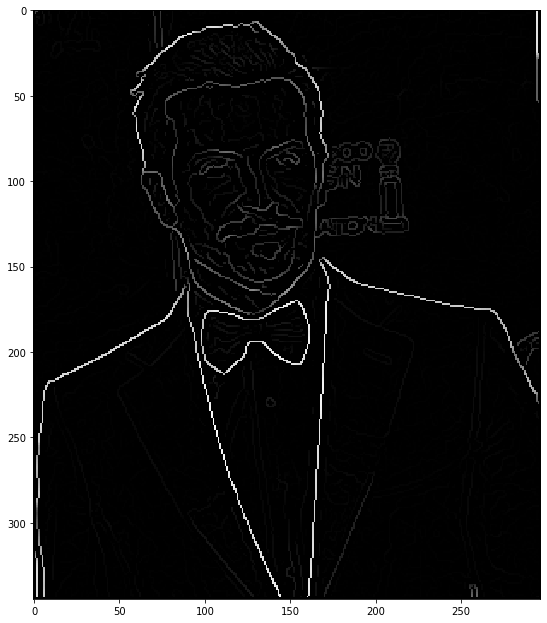

In [189]:
#TODO fix image edge handling
def non_max_suppression(img, D):
    Z = np.zeros_like(img)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,Z.shape[0]-1):
        for j in range(1,Z.shape[1]-1):
            try:
                q, r = 255, 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                    
            except IndexError as e:
                pass
    return Z

non_max_lad = non_max_suppression(sobel_lads[0], theta)

non_max_lads = [non_max_lad]
utils.visualize(non_max_lads, 'gray')

#assert (sobel_lads[0] == sobel_lads[1]).all()

255.0 0.0
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


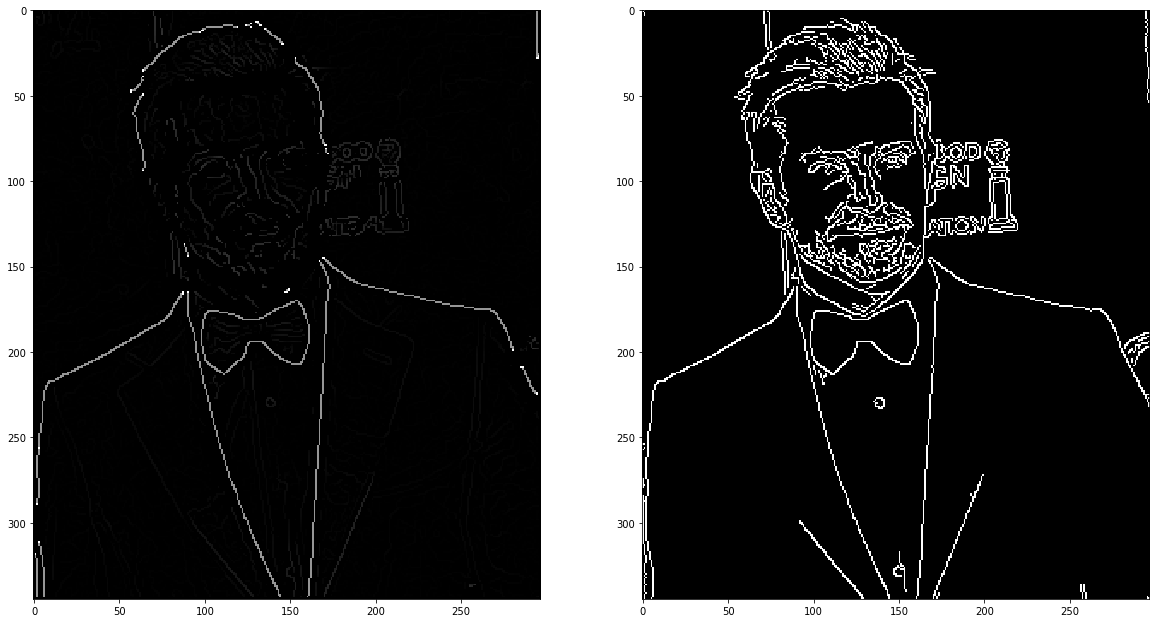

In [190]:
def double_threshold(img, low_thres=50, high_thres=150):
    assert len(img.shape) == 2 #must be greyscale img w/ dims=h*w
    highs, lows = [], []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] >= high_thres:
                #print('here')
                img[i,j] = high_thres
                highs.append((i,j))
            elif low_thres <= img[i,j] and img[i,j] <= high_thres:
                #print('here')
                img[i,j] = low_thres
                lows.append((i,j))
    return img, highs, lows


def hysteresis(img, weak, strong=255):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = 255
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img
print(np.max(non_max_lad), np.min(non_max_lad))
thres_lad, high_threholds, low_thresholds = double_threshold(non_max_lad)
canny_lad = hysteresis(thres_lad, 50, 150)
cv2_canny_lad = cv2.Canny(imgs[0].astype('uint8'), 50, 150)
canny_lads = [canny_lad, cv2_canny_lad] 
utils.visualize(canny_lads, 'gray')

